# NBA Game Predictions - Final Report
## Kevin Yang, Eric Lee, Derek Young


## Introduction
The NBA ([National Basketball Association](http://nba.com)) is an American based men's basketball league that is considered to be the leading basketball league in the world. As of the 2016-2017 season, there are 30 teams divided into two conferences (and further divided into six divisions). Each team participates in 82 games, with the potential of additional games if the team makes the playoffs. The season ends with a seven-game series between the finalists to determine the season's champion.

With technology at it's forefront, there has been a growth of data collection on NBA games, teams and players. NBA fans (as well as analysts!) have access to almost any statistic imaginable that the league collects. 
Our main objective is to utilize machine learning techniques to beat a naive approach in predicting which team will win given certain features. We will focus on Linear Regression, Logistic Regression and Support Vector Machines to see if these methods can give us an edge on predictions.

<a id="Report Contents"></a>
## Report Contents
Below outlines our approach to predict NBA game results.

1. [Data Collection](#Data Collection)
2. [Feature Creation](#Feature Creation)
    1. [Preprocessing Constant Features](#Preprocessing)
    2. [Adding Time-Sensitive Features](#Adding Time-Sesitive Features)
3. [Exploratory Data Analysis](#EDA)
    1. [Univariate Analysis](#Univariate Analysis)
    1. [Bivariate Analysis](#Bivariate Analysis)
    2. [Back-to-back games: Significance](#Back-to-Back)
    3. [The NBA over Time](#The NBA over Time)
4. [Feature Selection](#Feature Selection)
    1. [Training Cutoff](#Training Cutoff)
    2. ["N-Previous Games" Tuning](#N-Previous Games)
5. [Additional Features](#Additional Features)
    1. [Travel Distance](#Travel Distance) 
    2. [Altitude](#Altitude)
6. [Modeling](#Modeling)
    1. [Naive Approach](#Naive Approach)
    2. [Linear Regression](#Linear Regression)
    3. [Logistic Regression](#Logistic Regression)
    4. [Support Vector Machines](#SVM)
7. [Concluding Thoughts]()


While most of our project is written in Python, a certain subset was done in R, specifically modeling linear and logistic regression.

<a id='Data Collection'></a>
## 1. Data Collection

We found that the best place to get our data was [stats.nba.com](http://stats.nba.com). First, we surveyed the webpage, finding the location and organization of data. Using Google Chrome Developer Tools, we were able to find the link structures and JSON responses containing useful data for our models; these methods will be made more clear in the code below.

Once we found a scalable approach to get all team game data for any NBA season, we decided that it would be best if, upon scraping and collecting the appropriate data, that we store our data in a local `sqlite3` database for futher use. We found this to be a consistent and reliable approach to our data analysis, as our data does not run the risk of changing unexpectedly, and we do not have to worry about overloading any servers with too many requests. We write the functions `get_league_gamelogs`, `generate_year_list`, and `load_all_gamelogs` to collect and then store our data.


In [1]:
import requests
import sqlite3
import pandas as pd

def get_league_gamelogs(season):
    """ Given a season (string, ex: 2016-17), returns a (header, log_list) where the header represents a 
        key describing the format of the logs in log_list
    Input:
        season (str): season string, ex: '2016-17'
    Output:
        (list, dict)
    """
    league_log_url = ("http://stats.nba.com/stats/leaguegamelog?Counter=1000&DateFrom=&DateTo=&" + 
                  "Direction=DESC&LeagueID=00&PlayerOrTeam=T&Season=" + str(season) + 
                  "&SeasonType=Regular+Season&Sorter=PTS")
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; rv:39.0) Gecko/20100101 Firefox/39.0'}

    # Request URL and parse JSON
    response = requests.get(league_log_url, headers = headers)
    response.raise_for_status() # Raise exception if invalid response
    response_json = response.json()
    log_list = response_json['resultSets'][0]['rowSet']
    header = response_json['resultSets'][0]['headers']
    
    return (header, log_list)

def generate_year_list(start, yrs):
    """ Generate a year list to pass into load_all_gamelogs
    Input:
        start (int): The first year we are interested in loading
        yrs (int): How many years since start that we are including
    Output:
        (List): List of years
    """
    year_list = []
    curr_yr = start
    for i in xrange(yrs):
        nextyr = curr_yr + 1 
        year_list.append(str(curr_yr)+"-"+str(nextyr)[2:])
        curr_yr = nextyr
    return year_list
    
def load_all_gamelogs(conn, start, yrs):
    """ Load nba gamelog data for the past yrs years as a games tables into an sqlite database given in conn
    Input:
        conn (sqlite3.Connection): Connection object corresponding to the database; used to perform SQL commands.
        yrs (int): Number of years to include in table
    Output:
        None
    """
    
    cursor = conn.cursor()
    
    year_list = generate_year_list(start,yrs)
    
    # Clear any existing league_log table
    cursor.execute('drop table if exists league_log')
    
    # Create league_log table
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS league_log (
    season_id TEXT, team_id INTEGER, team_abbreviation TEXT, team_name TEXT, game_id INTEGER,
    game_date INTEGER, matchup INTEGER, wl STRING, min INTEGER, fgm INTEGER, fga INTEGER,
    fg_pct REAL, fg3m INTEGER, fg3a INTEGER, fg3_pct REAL, ftm INTEGER, fta INTEGER, ft_pct REAL,
    oreb INTEGER, dreb INTEGER, reb INTEGER, ast INTEGER, stl INTEGER, blk INTEGER, tov INTEGER,
    pf INTEGER, pts INTEGER, plus_minus INTEGER
    )""")
    
    for year in year_list:
        (header, log_list) = get_league_gamelogs(year)
        
        question_marks = "(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ? ,?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"
        query_string = "INSERT INTO league_log VALUES " + question_marks
        for log in log_list:
            cursor.execute(query_string,
                          (log[0],log[1],log[2],log[3],log[4],log[5],log[6],log[7],
                          log[8], log[9], log[10], log[11], log[12], log[13], log[14],
                          log[15],log[16], log[17], log[18], log[19], log[20], log[21],
                          log[22], log[23], log[24], log[25], log[26], log[27]))
            
    conn.commit()

In [2]:
# Connect to database file
conn = sqlite3.connect(r"db/league.db")
conn.text_factory = str

# Define relevant years
start_year = 1946
length = 2017 - start_year

load_all_gamelogs(conn, start_year, length)

# Load newly stored data into pandas DataFrame league_df
league_df = pd.read_sql_query('SELECT * FROM league_log', conn)
league_df.head()

,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,min,fgm,...,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,plus_minus
0,21946,1610610025,CHS,Chicago Stags,24600208,1947-02-06,CHS vs. PIT,W,0,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,109,24
1,21946,1610610025,CHS,Chicago Stags,24600284,1947-03-09,CHS @ CLR,W,0,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,107,30
2,21946,1610610025,CHS,Chicago Stags,24600280,1947-03-08,CHS vs. PRO,W,0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,107,26
3,21946,1610610036,WAS,Washington Capitols,24600199,1947-02-02,WAS @ CLR,W,0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,107,26
4,21946,1610610036,WAS,Washington Capitols,24600320,1947-03-26,WAS vs. CHS,W,0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,105,28


In [3]:
def validate_data(df):
    """ Given a DataFrame of league game logs, performs a few sanity checks based upon the number of games 
        in a season.
    Input:
        df (pd.DataFrame): league game logs
    Output:
        str
    """
    year_list = df['season_id'].unique().tolist()
    
    for year in year_list:
        df_temp = df[df['season_id'] == year]
        
        if year == '22011':
            # Lockout year
            assert(df_temp.shape[0] == 1980)
        elif year == '22016':
            # Current ongoing year
            continue
        elif year >= '22004':
            # Normal 30 team, 82 game schedule
            assert(df_temp.shape[0] == 2460) 
    return "Passed!"

print validate_data(league_df)

Passed!


We have now successfully collected and stored league log data for years ranging from `1946 - 2016`. Further, we have passed a few sanity checks to help ensure the correctness of our data. Notably, the head of league_df contains some NaN values; this is because there is a lack of data availability on certain older years on `stats.nba.com`. We print out the following to show more recent data from the 2005-06 season.

In [4]:
(league_df[league_df['season_id'] == "22005"]).head()

,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,min,fgm,...,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,plus_minus
86522,22005,1610612760,SEA,Seattle SuperSonics,20500589,2006-01-22,SEA @ PHX,W,290,54.0,...,10.0,35.0,45.0,21.0,9.0,3.0,19.0,24.0,152,3
86523,22005,1610612756,PHX,Phoenix Suns,20500589,2006-01-22,PHX vs. SEA,L,290,57.0,...,13.0,27.0,40.0,35.0,6.0,16.0,15.0,30.0,149,-3
86524,22005,1610612756,PHX,Phoenix Suns,20501067,2006-03-31,PHX @ TOR,W,240,51.0,...,8.0,24.0,32.0,37.0,10.0,3.0,8.0,20.0,140,14
86525,22005,1610612752,NYK,New York Knicks,20500438,2006-01-02,NYK vs. PHX,W,315,52.0,...,19.0,44.0,63.0,23.0,12.0,1.0,22.0,27.0,140,7
86526,22005,1610612743,DEN,Denver Nuggets,20500498,2006-01-10,DEN vs. PHX,W,315,51.0,...,12.0,34.0,46.0,27.0,7.0,5.0,17.0,26.0,139,2


<a id='Feature Creation'></a>
## 2. Feature Creation
Before running any exploratory data analysis, we need to preprocess our dataframe to include a few new columns. This is because each row in our current dataframe only contains data on postgame stats (i.e. points scored, win/loss), and does not contain any data that can be used as predictors before the game started. Based upon intuition and inspiration from other sources (mainly Amorim Torres [1]) we wanted to add the following features/columns:

1. is_home (indicator displaying 1 if the given team is playing at home, 0 otherwise)
2. opp_team_id (opposing team identifier)
3. wl_binary (indicator displaying 1 if the given team won, 0 otherwise)
4. home_win_pct (win percentage of the home team prior to the current game)
5. away_win_pct (win percentage of the away team prior to the current game)
6. home_avg_pt_diff (average point differential of the home team prior to the current game)
7. away_avg_pt_diff (average point differential of the away team prior to the current game)
8. home_win_pct_N (win percentage of the home team in the last N games prior to the current game)
9. away_win_pct_N (win percentage of the away team in the last N games prior to the current game)
10. home_win_pct_as_home (win percentage of the home team as home prior to the current game)
11. away_win_pct_as_away (win percentage of the away team as away prior to the current game)
12. home_back_to_back (indicator displaying 1 if the home team just played the day prior, 0 otherwise)
13. away_back_to_back (indicator displaying 1 if the away team just played the day prior, 0 otherwise)
14. home_game_count (number of games the home team as played prior to the current game)
15. away_game_count (number of games the away team as played prior to the current game)

We note that since the dynamics of NBA teams change greatly from season to season, all these features will
be season specific. For example, home_win_pct only considers the win percentage of the team in the games
within the current season. To create these features, we note that some of the features are not time-sensitive
(i.e. 1-3), while the other features 4-15 need to be ordered by time. Because of this, we will divide the
preprocessing into two functions, `add_constant_features` and `add_variable_features`, which add the 
constant features and the time-sensitive features respectively.

<a id='Preprocessing'></a>
### 2A. Preprocessing Constant Features
We first add the constant features (1-3 in the above list)

In [5]:
import numpy as np

def add_constant_features(league_df):
    """ Given a dataframe league_df, returns new league_df by converting the 'game_date' column to datetime if 
    necessary, and adds is_home indicator, opp_team_id, and wl_binary indicator
    Input:
        league_df (pandas.DataFrame): dataframe containing league logs
    Output:
        pd.DataFrame
    """
    # Convert to datetime, note that this is in place
    league_df['game_date'] = league_df['game_date'].apply(pd.to_datetime)
    
    # Add new columns
    is_home = np.zeros(len(league_df), dtype=np.int64)
    opp_team_id = np.zeros(len(league_df), dtype=np.int64)
    wl_binary = np.zeros(len(league_df), dtype = np.int64)
    
    league_df = league_df.assign(is_home = is_home)
    league_df = league_df.assign(opp_team_id = opp_team_id)
    league_df = league_df.assign(wl_binary = wl_binary)
    
    
    # Add home indicator variable
    for (index, row) in league_df.iterrows():
        matchup = row['matchup']
        if "@" in matchup:
            league_df.set_value(index, "is_home", 0)
        else:
            league_df.set_value(index, "is_home", 1)
            
    # Add opposing team ID
    for (index,row) in league_df.iterrows():
        game_id = row['game_id']
        team_id = row['team_id']
        
        # Find other game with the same game ID
        df_game = league_df[league_df['game_id'] == game_id]
        assert(len(df_game) == 2)
        found_opp = False
        for (inner_index,inner_row) in df_game.iterrows():
            curr_team_id = inner_row['team_id']
            if curr_team_id == team_id:
                continue
            else:
                # Found opposing team, update opposing team ID
                league_df.set_value(index, 'opp_team_id', curr_team_id)
                found_opp = True
        assert(found_opp)
        
    # Add binary representation of wins and losses
    for (index, row) in league_df.iterrows():
        wl = row['wl']
        if wl == 'W':
            league_df.set_value(index, 'wl_binary', 1)
        else:
            league_df.set_value(index, 'wl_binary', 0)
    
    return league_df

<a id='Adding Time-Sesitive Features'></a>
### 2B. Adding Time Sensitive Features
We now continue adding to our dataframe (4-15 in the list above). We use N = 8 as our lookback parameter ( our choice for that parameter is discused in the next section)

In [6]:
def add_variable_features(league_df, N=8):
    """ Given a dataframe league_df, returns a new df containing extra columns for each new feature.
        If new_years = true, adds features that only work for data frames containing data >= 2005
    Input:
        league_df (pandas.DataFrame): dataframe containing league logs
        N (int): lookback parameter
    Output:
        pd.DataFrame
    """    
    lookback = N
    new_df = league_df.sort_values('game_date')
    
    # Add new columns
    home_win_pct = np.zeros(len(new_df))
    away_win_pct = np.zeros(len(new_df))
    home_avg_pt_diff = np.zeros(len(new_df))
    away_avg_pt_diff = np.zeros(len(new_df))
    home_win_pct_N = np.zeros(len(new_df))
    away_win_pct_N = np.zeros(len(new_df))
    away_win_pct_as_away = np.zeros(len(new_df))
    home_win_pct_as_home = np.zeros(len(new_df))
    home_back_to_back = np.zeros(len(new_df))
    away_back_to_back = np.zeros(len(new_df))
    home_game_count = np.zeros(len(new_df))
    away_game_count = np.zeros(len(new_df))
    home_mileage = np.zeros(len(new_df))
    away_mileage = np.zeros(len(new_df))
    
    new_df = new_df.assign(home_win_pct = home_win_pct)
    new_df = new_df.assign(away_win_pct = away_win_pct)
    new_df = new_df.assign(home_avg_pt_diff = home_avg_pt_diff)
    new_df = new_df.assign(away_avg_pt_diff = away_avg_pt_diff)
    new_df = new_df.assign(home_win_pct_N = home_win_pct_N)
    new_df = new_df.assign(away_win_pct_N = away_win_pct_N)
    new_df = new_df.assign(away_win_pct_as_away = away_win_pct_as_away)
    new_df = new_df.assign(home_win_pct_as_home = home_win_pct_as_home)
    new_df = new_df.assign(home_back_to_back = home_back_to_back)
    new_df = new_df.assign(away_back_to_back = away_back_to_back)
    new_df = new_df.assign(home_game_count = home_game_count)
    new_df = new_df.assign(away_game_count = away_game_count)
    
    # add features
    grouped = new_df.groupby(['season_id'])
    groupList = [grouped.get_group(x) for x in grouped.groups]
    
    for season_df in groupList:
        # Initialize dictionary containing wins and losses for each team
        win_dict = dict()
        lose_dict = dict()
        running_dict = dict()
        
        # Stores list of game dates for each team
        running_date_dict = dict()
        
        # Total plus minus so far
        plus_minus_dict = dict()
        
        # Stores home and away game counts and w/l counts
        wins_as_home = dict()
        wins_as_away = dict()
        games_as_home = dict()
        games_as_away = dict()
        
        running_locations = dict()
        
        for team in season_df['team_id'].unique():
            win_dict[team] = 0
            lose_dict[team] = 0
            running_dict[team] = []
            plus_minus_dict[team] = 0
            running_date_dict[team] = []
            
            # Track wins at home, at away, and total games at home, at away
            wins_as_home[team] = 0
            wins_as_away[team] = 0
            games_as_home[team] = 0
            games_as_away[team] = 0
        
        # Sort season by day
        season_df = season_df.sort_values('game_date')
        
        seen_games = set()
        
        for (index, row) in season_df.iterrows():
            is_home = row['is_home']
            team_id = row['team_id']
            opp_team_id = row['opp_team_id']
            wl = row['wl']
            game_id = row['game_id']
            curr_team_plus_minus = row['plus_minus']
            opp_team_plus_minus = -curr_team_plus_minus
            game_date = row['game_date']
            
            season_id = row['season_id']
            
            if is_home == 1:
                home_team_id = team_id
                away_team_id = opp_team_id
            else:
                home_team_id = opp_team_id
                away_team_id = team_id
                
            # Update home_win_pct, away_win_pct
            home_win_pct = 0
            away_win_pct = 0

            if win_dict[home_team_id] + lose_dict[home_team_id] > 0:
                home_win_pct = (win_dict[home_team_id])/float(win_dict[home_team_id] + lose_dict[home_team_id])
            if win_dict[away_team_id] + lose_dict[away_team_id] > 0:
                away_win_pct = (win_dict[away_team_id])/float(win_dict[away_team_id] + lose_dict[away_team_id])
                
            new_df.set_value(index, 'home_win_pct', home_win_pct)
            new_df.set_value(index, 'away_win_pct', away_win_pct)
            
            # Update home_win_pct_N, away_win_pct_N
            home_win_pct_N = 0
            away_win_pct_N = 0
            
            home_games_count = len(running_dict[home_team_id])
            away_games_count = len(running_dict[away_team_id])
            
            new_df.set_value(index, 'home_game_count', home_games_count)
            new_df.set_value(index, 'away_game_count', away_games_count)
            
            if home_games_count > 0:
                if home_games_count > lookback:
                    lookback_games = running_dict[home_team_id][home_games_count - lookback:]
                else:
                    lookback_games = running_dict[home_team_id]
                home_win_pct_N = sum(lookback_games)/float(len(lookback_games))
                
            if away_games_count > 0:
                if away_games_count > lookback:
                    lookback_games = running_dict[away_team_id][away_games_count - lookback:]
                else:
                    lookback_games = running_dict[away_team_id]
                away_win_pct_N = sum(lookback_games)/float(len(lookback_games))
                
            new_df.set_value(index, 'home_win_pct_N', home_win_pct_N)
            new_df.set_value(index, 'away_win_pct_N', away_win_pct_N)
            
            # Update home_avg_pt_diff, away_avg_pt_diff
            home_avg_pt_diff = 0
            away_avg_pt_diff = 0
            
            if home_games_count > 0:
                running_pt_diff = plus_minus_dict[home_team_id]
                home_avg_pt_diff = running_pt_diff/float(home_games_count)
            if away_games_count > 0:
                running_pt_diff = plus_minus_dict[away_team_id]
                away_avg_pt_diff = running_pt_diff/float(away_games_count)
                
            new_df.set_value(index, 'home_avg_pt_diff', home_avg_pt_diff)
            new_df.set_value(index, 'away_avg_pt_diff', away_avg_pt_diff)
            
            # Update back-to-back indicators   
            home_back_to_back = 0
            away_back_to_back = 0
            
            if home_games_count > 0:
                most_recent_date = running_date_dict[home_team_id][home_games_count - 1]
                
                if game_date.toordinal() - most_recent_date.toordinal() == 1:
                    # Back-to-back
                    home_back_to_back = 1
                
            if away_games_count > 0:
                most_recent_date = running_date_dict[away_team_id][away_games_count - 1]
                
                if game_date.toordinal() - most_recent_date.toordinal() == 1:
                    # Back-to-back
                    away_back_to_back = 1
                    
            new_df.set_value(index, 'home_back_to_back', home_back_to_back)
            new_df.set_value(index, 'away_back_to_back', away_back_to_back)
            
            # Update home_win_pct_as_home, away_win_pct_as_away
            home_win_pct_as_home = 0
            away_win_pct_as_away = 0
            
            home_games_as_home = games_as_home[home_team_id]
            away_games_as_away = games_as_away[away_team_id]
            
            if (home_games_as_home > 0):
                home_win_pct_as_home = (wins_as_home[home_team_id])/float(home_games_as_home)
            if (away_games_as_away > 0):
                away_win_pct_as_away = (wins_as_away[away_team_id])/float(away_games_as_away)
                
            new_df.set_value(index, 'home_win_pct_as_home', home_win_pct_as_home)
            new_df.set_value(index, 'away_win_pct_as_away', away_win_pct_as_away) 
                
            # Update running stats
            if (wl == 'W'):
                if game_id in seen_games:
                    win_dict[team_id] += 1
                    lose_dict[opp_team_id] += 1
                    running_dict[team_id].append(1)
                    running_dict[opp_team_id].append(0)
                    
                    # Update home team and away team w/l
                    if is_home == 1:
                        wins_as_home[team_id] += 1
                        games_as_home[team_id] += 1
                        games_as_away[opp_team_id] += 1
                    else:
                        wins_as_away[team_id] += 1
                        games_as_away[team_id] += 1
                        games_as_home[opp_team_id] += 1
                    
            else:
                if game_id in seen_games:
                    win_dict[opp_team_id] += 1
                    lose_dict[team_id] += 1
                    running_dict[opp_team_id].append(1)
                    running_dict[team_id].append(0)
                    
                    # update home team and away team w/l
                    if is_home == 1:
                        wins_as_away[opp_team_id] += 1
                        games_as_away[opp_team_id] += 1
                        games_as_home[team_id] += 1
                        
                    else:
                        wins_as_home[opp_team_id] += 1
                        games_as_home[opp_team_id] += 1
                        games_as_away[team_id] += 1
            if game_id in seen_games:
                plus_minus_dict[team_id] += curr_team_plus_minus
                plus_minus_dict[opp_team_id] += opp_team_plus_minus
                running_date_dict[team_id].append(game_date)
                running_date_dict[opp_team_id].append(game_date)
                
#                 if (new_years):
#                     running_locations[home_team_id].append(curr_location)
#                     running_locations[away_team_id].append(curr_location)
                
            seen_games.add(game_id)
    return new_df

In [7]:
all_games = add_variable_features(add_constant_features(league_df))
home_games = all_games[all_games['is_home'] == 1]
all_games.head()

,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,min,fgm,...,home_avg_pt_diff,away_avg_pt_diff,home_win_pct_N,away_win_pct_N,away_win_pct_as_away,home_win_pct_as_home,home_back_to_back,away_back_to_back,home_game_count,away_game_count
324,21946,1610612752,NYK,New York Knicks,24600001,1946-11-01,NYK @ HUS,W,0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368,21946,1610610035,HUS,Toronto Huskies,24600001,1946-11-01,HUS vs. NYK,L,0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
556,21946,1610610034,BOM,St. Louis Bombers,24600003,1946-11-02,BOM vs. PIT,W,0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
609,21946,1610610031,PIT,Pittsburgh Ironmen,24600003,1946-11-02,PIT @ BOM,L,0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
614,21946,1610610036,WAS,Washington Capitols,24600005,1946-11-02,WAS @ DEF,W,0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


From the output above, we can see some of the new columns we added. However, we see that most of the values are 0, which is expected since the head of the dataframe contains data from the beginning of a season. To display some of our results, we will show the dataframe tail.

In [8]:
all_games.tail()

,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,min,fgm,...,home_avg_pt_diff,away_avg_pt_diff,home_win_pct_N,away_win_pct_N,away_win_pct_as_away,home_win_pct_as_home,home_back_to_back,away_back_to_back,home_game_count,away_game_count
113541,22016,1610612748,MIA,Miami Heat,21600350,2016-12-10,MIA @ CHI,L,240,42.0,...,3.045455,-3.652174,0.375,0.250,0.384615,0.666667,0.0,1.0,22.0,23.0
113159,22016,1610612743,DEN,Denver Nuggets,21600347,2016-12-10,DEN @ ORL,W,240,47.0,...,-5.166667,-3.000000,0.500,0.250,0.384615,0.363636,1.0,0.0,24.0,23.0
113107,22016,1610612746,LAC,LA Clippers,21600355,2016-12-10,LAC vs. NOP,W,240,54.0,...,8.434783,-3.478261,0.375,0.250,0.200000,0.636364,0.0,0.0,23.0,23.0
113299,22016,1610612757,POR,Portland Trail Blazers,21600348,2016-12-10,POR @ IND,L,240,40.0,...,-3.086957,-2.333333,0.500,0.500,0.384615,0.666667,1.0,0.0,23.0,24.0
113457,22016,1610612762,UTA,Utah Jazz,21600354,2016-12-10,UTA vs. SAC,W,240,37.0,...,4.375000,-1.000000,0.750,0.375,0.333333,0.583333,0.0,1.0,24.0,22.0


<a id='EDA'></a>
## 3. Exploratory Data Analysis
We do some exploratory data analysis of our collected NBA data in order to give us helpful insight that will be useful for us when we ultimately decide what type of variables would be useful predictors for our model. Our EDA will include examining variables both univariately and bi-variately.

<a id='Univariate Analysis'></a>
### 3A. Univariate Analysis
We note from the below figure:
- our response variable `plus-minus` is unimodal around 0 points and normally distributed 
- predictor variables `home/away_win_pct` and `home/away_win_pct_N`  are unimodal around 50% and normally distributed 
- `home_win_pct_as_home` is right skewed, with mode at around 60%
- `away_win_pct_as_away` is left skewed, with mode at around 40%
- most games are not back to back
- there are two teams (Denver Nuggets and Utah Jazz) that have stadiums at very high elevations
- it is more common for a team to travel relatively shorter distances than longer distances (right skewed distributions for both `home_mileage` and `away_mileage`
<img src="univariate.png">

<a id='Bivariate Analysis'></a>
### 3B. Bivariate Analysis
Based on our personal intuition and understanding of the NBA, we listed out some of the variables that we wanted to explore with the understanding that these variables could potentially be important factors in determining which team will win a given matchup. For all of the following variables, we explored bivariate scatterplots, graphing the home team's data on the y axis against the away team's data on the x axis. For our plots concerning the home and away win/loss percentage in the previous N games, we choose 8 games for the purpose of these graphs. A more detailed analysis on how we pick N is discussed in a different section.

1. Home W/L Percentage
2. Away W/L Percentage
3. Home Average Point Differential
4. Away Average Point Differential
5. Home W/L Percentage in Previous N Games (8 chosen here for the plots)
6. Away W/L Percentage in Previous N Games (8 chosen here for the plots)
7. Away W/L Percentage as Away Team
8. Home W/L Percentage as Home Team

Running these graphs over multiple seasons and eyeballing the plots gave us similar results. As an example, we display and inspect these graphs for the most recently completed season (2015-16). Each of the points are color coded: games that were won by the home team are blue while lost games are red. Hovering over each point displays the home team, the teams matched up, and an boolean value of whether or not the away team was playing a back to back game (1 for back to back, 0 for not).

In [11]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.charts import Bar
from bokeh.charts import Scatter
from bokeh.io import output_notebook
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook

# Plot of Home W/L Percentage vs. Away W/L Percentage
#all_years_id = home_games_with_cutoff["season_id"].unique()
all_years_id = home_games["season_id"].unique()
# Look at the previous completed season
#testYear =  home_games_with_cutoff[(home_games_with_cutoff["season_id"] =="22015")]
testYear =  home_games[(home_games["season_id"] =="22015")]

# Based on home team, color losses as red and wins as blue 
colormap = {'L': 'red', 'W': 'blue', }
colors = [colormap[x] for x in testYear["wl"]]

# Import the nba dataframe of the given year as ColumnDataSource 
source = ColumnDataSource(data=testYear)

# Variables we want to show in the hover: university name and ranking
hover = HoverTool(tooltips=[("Home", "@team_abbreviation"), ("Game", "@matchup"), ("Away BB", "@away_back_to_back")])

# Add in labels to the graph
yearNum = "2015"
title = "Home Vs. Away - Win/Loss % Year " + yearNum
p = figure(title = title, tools = [hover, "resize", "box_zoom", "reset"])
p.xaxis.axis_label = 'Away Team W/L %'
p.yaxis.axis_label = 'Home Team W/L %'

# Plot the points for the graph
p.circle(testYear["away_win_pct"], testYear["home_win_pct"], color=colors, fill_alpha=0.2, size=10, source = source)
# Add a line of slope one to visually divide points
p.line([0, 1], [0, 1], line_width=2, color = "black")

# Display inline
output_notebook()
show(p)

Loading BokehJS ...

<img src="WinLoss.png", width = 500, height = 500>

In this graph, what we can see is that the games above the clearly line tend to have more wins than games below the line. This goes to show that the team with a higher win/loss percentage tends to win more matchups. This pattern in the graph supports the idea that win loss percentage can be an important predictor for modeling NBA game outcomes. 

In [12]:
# Plot of Home Avg Pt Diff vs. Away Avg Pt Diff
#all_years_id = home_games_with_cutoff["season_id"].unique()
all_years_id = home_games["season_id"].unique()
# Look at the previous completed season
#testYear =  home_games_with_cutoff[(home_games_with_cutoff["season_id"] =="22015")]
testYear =  home_games[(home_games["season_id"] =="22015")]
# Based on home team, color losses as red and wins as blue 
colormap = {'L': 'red', 'W': 'blue', }
colors = [colormap[x] for x in testYear["wl"]]

# Import the nba dataframe of the given year as ColumnDataSource
source = ColumnDataSource(data=testYear)

# Variables we want to show in the hover: university name and ranking
hover = HoverTool(tooltips=[("Home", "@team_abbreviation"), ("Game", "@matchup"), ("Away BB", "@away_back_to_back")])

# Add in labels to the graph
yearNum = "2015"
title = "Home Vs. Away - Avg Pt Diff Year " + yearNum
p = figure(title = title, tools = [hover, "resize", "box_zoom", "reset"])
p.xaxis.axis_label = 'Away Team Avg Pt Diff'
p.yaxis.axis_label = 'Home Teams Avg Pt Diff'

# Plot the points for the graph
p.circle(testYear["away_avg_pt_diff"], testYear["home_avg_pt_diff"], color=colors, fill_alpha=0.2, size=10, source = source)
# Add a line of slope one to visually divide points
p.line([-15, 15], [-15, 15], line_width=2, color = "black")

# Display inline
output_notebook()
show(p)

Loading BokehJS ...

<img src="AvgPtDiff.png", width = 500, height = 500>

Again, we see that the games above the line clearly tend to have more wins than games below the line, showing that the team with a higher avg pt differential tends to win more matchups. This pattern in the graph supports the idea that this variable can be an important predictor for modeling NBA game outcomes. 

In [13]:
# Plot of Home W/L Percentage Previous N Games vs. Away W/L Percentage Previous N games
#all_years_id = home_games_with_cutoff["season_id"].unique()
all_years_id = home_games["season_id"].unique()
# Hard code the year we are looking at for now
#testYear =  home_games_with_cutoff[(home_games_with_cutoff["season_id"] =="22015")]
testYear =  home_games[(home_games["season_id"] =="22015")]
# Based on home team, color losses as red and wins as blue 
colormap = {'L': 'red', 'W': 'blue', }
colors = [colormap[x] for x in testYear["wl"]]

# Import the nba dataframe of the given year as ColumnDataSource
source = ColumnDataSource(data=testYear)

# Variables we want to show in the hover: university name and ranking
hover = HoverTool(tooltips=[("Home", "@team_abbreviation"), ("Game", "@matchup"), ("Away BB", "@away_back_to_back")])

# Add in labels to the graph
yearNum = "2015"
title = "Home Vs. Away - Win/Loss % Last 8 Games " + yearNum
p = figure(title = title, tools = [hover, "resize", "box_zoom", "reset"])
p.xaxis.axis_label = 'Away Team Win/Loss % Last 8 Games'
p.yaxis.axis_label = 'Home Team Win/Loss % Last 8 Games'

# Plot the points for the graph
p.circle(testYear["away_win_pct_N"], testYear["home_win_pct_N"], color=colors, fill_alpha=0.2, size=10, source = source)
p.line([0, 1], [0, 1], line_width=2, color = "black")

# Display inline
output_notebook()
show(p)

Loading BokehJS ...

<img src="WinLossLastN.png", width = 500, height = 500>

For this plot, a lot of the points have different shades because there are multiple games with different outcomes that lie at the same point. Again, we see that the games above the line clearly tend to have more wins than games below the line, showing that the team with a higher win/loss percentage in the last 8 games ends up winning more matchups. This pattern in the graph supports the idea that this variable can be an important predictor for modeling NBA game outcomes. 

In [14]:
# Plot of Home Team W/L Percentage as Home vs. Away W/L Percentage as Away 
#all_years_id = home_games_with_cutoff["season_id"].unique()
all_years_id = home_games["season_id"].unique()
# Hard code the year we are looking at for now
#testYear =  home_games_with_cutoff[(home_games_with_cutoff["season_id"] =="22015")]
testYear =  home_games[(home_games["season_id"] =="22015")]
# Based on home team, color losses as red and wins as blue 
colormap = {'L': 'red', 'W': 'blue', }
colors = [colormap[x] for x in testYear["wl"]]

# Import the nba dataframe of the given year as ColumnDataSource
source = ColumnDataSource(data=testYear)

# Variables we want to show in the hover: university name and ranking
hover = HoverTool(tooltips=[("Home", "@team_abbreviation"), ("Game", "@matchup"), ("Away BB", "@away_back_to_back")])

# Add in labels to the graph
yearNum = "2015"
title = "Home Win % as Home vs Away Win % as Away " + yearNum
p = figure(title = title, tools = [hover, "resize", "box_zoom", "reset"])
p.xaxis.axis_label = 'Away Team Win/Loss as Away Team'
p.yaxis.axis_label = 'Home Team Win/Loss as Home Team'

# Plot the points for the graph
p.circle(testYear["away_win_pct_as_away"], testYear["home_win_pct_as_home"], color=colors, fill_alpha=0.2, size=10, source = source)
p.line([0, 1], [0, 1], line_width=2, color = "black")

# Display inline
output_notebook()
show(p)

Loading BokehJS ...

<img src="HomeAsHome%.png", width = 500, height = 500>

Again, we see that the games above the line clearly tend to have more wins than games below the line, showing that home teams with a higher win/loss percentage as the home team are more likely to win matchups, and vice versa. This pattern in the graph supports the idea that this variable can be an important predictor for modeling NBA game outcomes. 

<a id='Back-to-Back'></a>
### 3C. Hypothesis Testing: Is Back to Back 
Another variable that we believed to be an important predictor to the outcome of NBA games was whether or not either of the teams playing in the current matchup had just played a game the day before, as teams playing consequtive games are likely to be more tired and more likely to lose than if they were well rested. 

We evaluate this claim with hypothesis testing. For each team in the league, we will look back throughout several seasons and calculate their win/loss percentages for regular games and back to back games. We then run a difference in proportions hypothesis test to see whether or not there is a statistically significant difference between these win/loss percentages. Because we already intuitively believe that playing back to back games will lower a given team's chances of winning, this hypothesis test will be one sided. The hypothesis test below was run at an alpha level of 0.05. The null and alternative hypotheses are listed below:

#### Null Hypothesis: 
The true difference in this team's win/loss percentages between regular games and back to back games is zero.
#### Alternative Hypothesis: 
The true difference in this team's win/loss percentages between regular games and back to back games is non-zero.

In [15]:
import scipy.stats as st
from scipy.stats import t
from scipy.stats import norm

def teamPercentages(teamID, game_log):
    """ Given a team id (int) returns a (list, list) representing win loss percentages for back to back 
        and regular games
    Input:
        teamID (int): team_id number
        game_log (pd.DataFrame): Game_log that which lists all the home games 
    Output:
        (list, list): Tuple of lists where each list contains the number of wins and number of games played for a 
                      given category, where the first list represents back to back games and the second list 
                      represents regular games.
    """
    seasons = game_log["season_id"].unique()
    # Initialize lists which store the percentages for back to back games and regular games for each season
    bbList = []
    regList = []
    # Initialize counters for games 
    bbWins = 0 
    bbGames = 0
    regWins = 0
    regGames = 0
    # Iterate through all seasons of the dataframe 
    for season in seasons:
        # Get dataframe that only contains games from this season of the team of interest
        currDf = game_log[(game_log["season_id"] == season) & ((game_log["team_id"] == teamID) | (game_log["opp_team_id"] == teamID))]
        # Iterate over the dataframe
        for (index, row) in currDf.iterrows():
            # Determine whether this is a home or away game
            if (row["team_id"] == teamID):
                home = True
            else:
                home = False
            # Case 1: Home back to back game 
            if (home and row["home_back_to_back"] == 1):
                bbGames += 1
                if (row["wl_binary"] == 1):
                    bbWins += 1
            # Case 2: Away back to back game
            if(home == False and row["away_back_to_back"] == 1):
                bbGames += 1
                if (row["wl_binary"] == 0):
                    bbWins += 1
            # Otherwise we have regular games
            else:
                regGames += 1
                if (home and row["wl_binary"] == 1):
                    regWins += 1
                elif (home == False and row["wl_binary"] == 0):
                    regWins += 1
    # Add the num of won and total games in the respective lists 
    bbList.append(bbWins)
    bbList.append(bbGames)
    regList.append(regWins)
    regList.append(regGames)
    return (bbList, regList)

def leaguePercentages(game_log, season_id):
    """ For all teams in the league, generate their win loss percentages for back to back and regular games 
        across all seasons from data from a given season onwards, storing the result in a dictionary. 
    Input: 
        game_log (pd.Dataframe): Dataframe containing all the home games
        season_id (string): season id in which we only look at the results occuring at or after this season 
    Output:
        returnDict: (string, (List, List)) where key represents the team name and value is a tuple of 
                                           lists. Each list contains the number of wins and total games played, 
                                           where the first list represents back to back games and the second list 
                                           represents regular games
    """
    # Index out the seasons 
    newLog = game_log[game_log["season_id"] >= season_id]
    # Initialize the dictionary for all teams
    returnDict = {}
    teamList = newLog["team_id"].unique()
    # Iterate over all teams and call above helper function to generate the lists of win loss % for each team
    for teamID in teamList:
        returnDict[team] = teamPercentages(teamID, newLog)
    return returnDict

def hypothesisTest(bbList, regList):
    """ Run a hypothesis test to see whether the true mean win loss percentage of regular games is higher than
        the true mean win loss percentage of back to back games for a specific team over many seasons (alpha = 0.05).
    Input: 
        bbList (List): List containing the win loss percentages of a team for back to back games over many seasons
        regList (List): List containing the win loss percentages of a team for regular games over many seasons 
    Output:
        result: (Boolean) where 1 represents regular game win loss percentage being significantly greater than the 
                          win loss percentage for back to back games given the inputted data.
    """
    # Get number of back to back and reg games 
    bbWins = bbList[0]
    nBB = bbList[1]
    regWins = regList[0]
    nReg = regList[1]
    # Get our win loss percentages for back to back and regular games 
    bbProp = bbWins / float(nBB)
    regProp = regWins / float(nReg)
    # Caluclate the pooled proportion and pooled standard deviation 
    pooledProp = (bbWins + regWins) / float(nBB + nReg)
    pooledSE = np.sqrt(pooledProp * (1 - pooledProp) * ((1/float(nBB)) + (1/float(nReg))))
    propDiff = regProp - bbProp
    z = propDiff / float(pooledSE)
    # Find the cutoff for alpha = 0.05 
    cutoff = norm.ppf(0.95, loc = 0, scale = 1)
    return z > cutoff 
    
def testLeague(game_log, season_id):
    """ For all teams in the league, run the hypothesis tests comparing win loss percentages between regular and 
        back to back games.
    Input: 
        game_log (pd.Dataframe): Dataframe containing home game logs 
        season_id (string): season_id in which we only look at the results occuring at or after this season  
    Output:
        result: (Float, Dictionary) Tuple containing an int and a dictionary. The float represents the percentage of teams
                                    in which back to back games is significant from the hypothesis test. The dictionary 
                                    has keys being the team_id, and values as booleans of whether or not there was a 
                                    significant difference between the records
    """
    # Index out the seasons 
    newLog = game_log[game_log["season_id"] >= season_id]
    # Initialize the dictionary for all teams
    returnDict = {}
    teamList = newLog["team_id"].unique()
    for team in teamList:
        returnDict[team] = hypothesisTest(teamPercentages(team, newLog[newLog["season_id"] >= season_id])[0], teamPercentages(team, all_games[all_games["season_id"] >= season_id])[1])
    # Find the proportion of teams in which this difference was significant across the league 
    sig = 0 
    total = 0 
    for team in returnDict:
        if returnDict[team] == 1:
            sig += 1
        total += 1
    percSig = (sig) / float(total)
    # Print the percentage of teams in which back to back is a significant variable 
    print percSig
    return (percSig, returnDict)

testLeague(home_games, "22005")

0.533333333333


(0.5333333333333333,
 {1610612737: False,
  1610612738: False,
  1610612739: True,
  1610612740: True,
  1610612741: False,
  1610612742: False,
  1610612743: True,
  1610612744: False,
  1610612745: True,
  1610612746: False,
  1610612747: True,
  1610612748: False,
  1610612749: False,
  1610612750: True,
  1610612751: True,
  1610612752: False,
  1610612753: False,
  1610612754: True,
  1610612755: True,
  1610612756: True,
  1610612757: False,
  1610612758: True,
  1610612759: True,
  1610612760: True,
  1610612761: False,
  1610612762: True,
  1610612763: True,
  1610612764: True,
  1610612765: False,
  1610612766: False})

#### Result
The above code ran the hypothesis test comparing win/loss percentages between regular and back to back games across all teams in the league from the 2005 season to the games that have occured in the current (2016-2017) season. As the results show, for our data collected from the 2005 season and on, at an alpha level of 0.05, we see that there is statistically significant evidence to reject the null in favor of the alternative that teams have a worse record on back to back games compared to regular games, for 53% of teams in the league. Thus, we decide that back to back is a significant predictor that should be included in our model. 

<a id='The NBA over Time'></a>
### 3D. How has the NBA changed over the years?
We want to examine the change of key statistics over time in the past 40 years of the NBA. 
1. How has the standard deviation of team wins in a given season changed over different seasons?
2. How has the average point differential for a given season changed over different seasons?
3. How has the difference between the mean point differential between top teams and bottom teams changed over different seasons?

Knowing how the league has changed in terms of these potential predictors is key to better understanding and optimizing our model to how the league currently operates and whether the certain variables are likely vary a lot throughout different seasons or are more stable. The following code addresses these questions by generating visualizations on these different values across the past 40 seasons. 

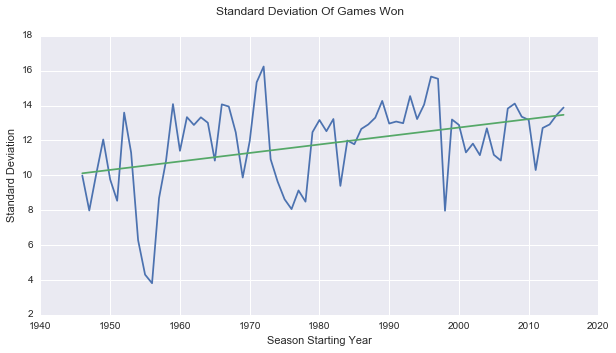

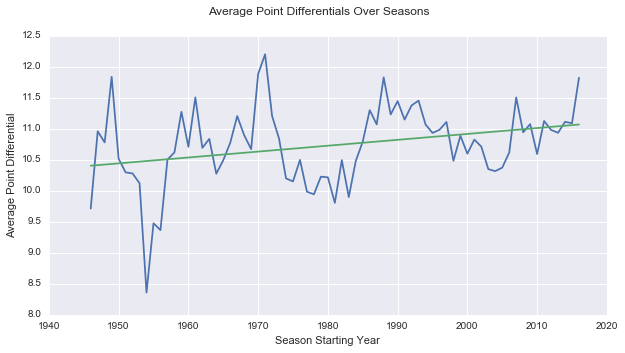

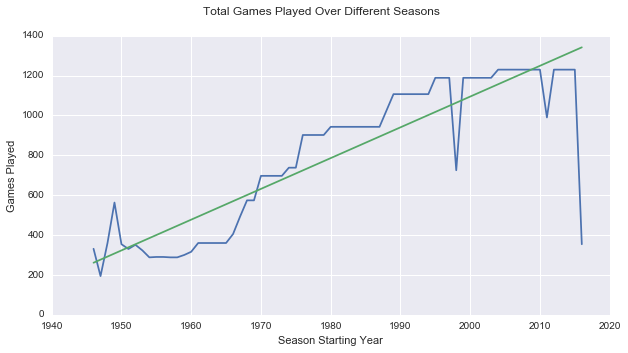

In [17]:
import matplotlib
matplotlib.use("svg")
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)
def get_team_wins_count(league_df, team_id, season_id):
    """ Given a df containing ALL game logs (including home and away), 
        team_id and season_id, returns number of wins the team got that season
    Input:
        league_df (pandas.DataFrame): dataframe containing post-processed league logs (both HOME and AWAY)
        team_id (int or string): player ID number
        season_id (int or string): season ID number
    Output:
        (int): number of games team won in season
    """ 
    team_id = int(team_id)
    season_id = str(season_id)
    
    temp_df = league_df[(league_df['season_id'] == season_id) & (league_df['team_id'] == team_id)]
    temp_df = temp_df.sort_values('game_date')
    
    # get last game
    last_game = temp_df.iloc[len(temp_df) - 1]

    wins = 0
    games_won_so_far = 0
    if last_game['is_home']:
        games_won_so_far = int(round(last_game['home_win_pct']*last_game['home_game_count']))
    else:
        games_won_so_far = int(round(last_game['away_win_pct']*last_game['away_game_count']))
    wins = games_won_so_far + last_game['wl_binary']
    return wins
    
get_team_wins_count(all_games, "1610612742", "22004")

def graph_stdev_wins(league_df):
    """ Given a df containing ALL SORTED game logs (including home and away), 
        graphs stdev of team wins over time
    Input:
        league_df (pandas.DataFrame): dataframe containing post-processed league logs (both HOME and AWAY)
    Output:
        None
    """
    season_list = league_df['season_id'].unique().tolist()
    seasons = []
    stdevs = []
    for season in season_list:
        season_df = league_df[league_df['season_id'] == season]
        team_list = season_df['team_id'].unique().tolist()
        win_counts = []
        for team in team_list:
            team_wins = get_team_wins_count(league_df, team, season)
            win_counts.append(team_wins)
        stdev = np.array(win_counts).std(ddof = 1)
        seasons.append(int(season[1:]))
        stdevs.append(stdev)
        
    # remove last, unfinished year
    seasons = seasons[:len(seasons)- 1]
    stdevs = stdevs[:len(stdevs) - 1]
    fig = plt.figure()
    fig.suptitle('Standard Deviation Of Games Won',fontsize=12)
    plt.xlabel('Season Starting Year')
    plt.ylabel('Standard Deviation')
    plt.plot(seasons, stdevs, seasons, 
                  np.poly1d(np.polyfit(seasons, stdevs, 1))(np.unique(seasons)))
         
graph_stdev_wins(all_games)

def graph_avg_ptdiff(league_df):
    """ Given a df containing ALL SORTED game logs (including home and away), 
        graphs average (absolute value) ptdiff over seasons
    Input:
        league_df (pandas.DataFrame): dataframe containing post-processed league logs (both HOME and AWAY)
    Output:
        None
    """
    season_list = league_df['season_id'].unique().tolist()
    seasons = []
    avg_pt_diffs = []
    for season in season_list:
        season_df = league_df[league_df['season_id'] == season]
        pt_diff = season_df['plus_minus'].values
        pt_diff = np.apply_along_axis(lambda x: np.abs(x), 0, pt_diff)
        seasons.append(int(season[1:]))
        avg_pt_diffs.append(np.mean(pt_diff))
    fig = plt.figure()
    fig.suptitle('Average Point Differentials Over Seasons',fontsize=12)
    plt.xlabel('Season Starting Year')
    plt.ylabel('Average Point Differential')
    plt.plot(seasons, avg_pt_diffs, seasons, 
                  np.poly1d(np.polyfit(seasons, avg_pt_diffs, 1))(np.unique(seasons)))

graph_avg_ptdiff(all_games)
    
def total_games_graph(league_df):
    """ Given a df containing ALL HOME game logs, 
        graphs total games played throughout seasons
    Input:
        league_df (pandas.DataFrame): dataframe containing post-processed league logs (only HOME)
    Output:
        None
    """
    season_list = league_df['season_id'].unique().tolist()
    seasons = []
    total_games = []
    for season in season_list:
        season_df = league_df[league_df['season_id'] == season]
        seasons.append(int(season[1:]))
        total_games.append(len(season_df))
    fig = plt.figure()
    fig.suptitle('Total Games Played Over Different Seasons',fontsize=12)
    plt.xlabel('Season Starting Year')
    plt.ylabel('Games Played')
    plt.plot(seasons, total_games, seasons, 
                  np.poly1d(np.polyfit(seasons, total_games, 1))(np.unique(seasons)))
    
total_games_graph(home_games)

Its clear that the first two plots show that the standard deviation of games won and average point differentials have wave-like patterns that are only slowly increasing as a whole (looking across the wave patterns). The increasing trend of the standard deviation of the number of games won shows us that there exists a larger spread of games won throughout the league within a season as we move to more current seasons, indicating there are likely larger gaps between good and bad teams in the league. This could possibly be due to the increasing number of teams in the league. Similarly, the increasing trend in average point differential also supports this idea of a larger gap between good and bad teams, as average point differntials are larger in more current seasons. 

These effects, however, do not seem particularly large, as the total increase for the standard deviation of games won and average point differential are 4 and 0.5, respectively.

Where we do notice a larger effect is in the total games played graph. We see that the number has been increasing from seasons 1940 to 1990, where it starts to level off. Note that the last point on the total number of games played across seasons is lower because it is the current season which is still in progress. Additionally, the years 1989 and 2011 show dips in the plot due to the lockout season, in which the seasons were condensed. This is important when considering the scope of our data in terms of considering which seasons to include. Seasons after 1990 and after are a lot more similar to the number of total games played currently in the NBA, while going back further and further becomes increasingly different in terms of number of games played. 

<a id='Feature Selection'></a>
## 4. Feature Selection
Now that we have done some initial data analysis, we would like to fine tune a couple of our features. Specifically, we take a look at the `home-win percentage` and `N-Previous games home-win percentage`. 

<a id='Training Cutoff'></a>
### 4A. Training Cutoff

While we have data on the running home win percentage for any particular season, we still have to take caution about games that are played at the beginning of the season. At that stage of the season, when there are not many games yet played, the home win percentage can flucuate wildly (i.e 100% to 50% to 66%). To prevent some of the noise in this particular features, we would like to cut off "N" number of games at the start of the season. To determine what this "N" is, we plot the change in home-win-percentage against the number of games played. To get a sufficient sample size, we use all and seasons from the 1947 all the way to the present. 

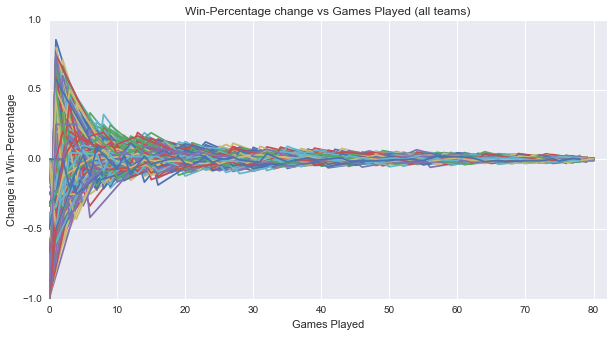

In [19]:
def check_cutoff_value(df):
    """ Given a dataframe of game logs, display a graph showing the change 
        in win percentage per team as a season progresses
    Input:
        df (pd.DataFrame): Game_log
    Output:
        (None)
    """
    all_years_id = home_games["season_id"].unique()
    for year in all_years_id:
        curr_year = home_games[(home_games["season_id"] ==year)]
        all_teams = curr_year["team_abbreviation"].unique()
        for team in all_teams:
            newdf = curr_year[(curr_year["team_abbreviation"] ==team)]
            temp = newdf['home_win_pct'] - newdf['home_win_pct'].shift(-1) # difference in win_pct
            plt.plot(newdf["home_game_count"],temp)
    plt.axis([0,82,-1,1])
    plt.xlabel('Games Played')
    plt.ylabel('Change in Win-Percentage')
    plt.title('Win-Percentage change vs Games Played (all teams from 1947 onwards)')

check_cutoff_value(home_games)

We decide on a cutoff value of N = 10. This allows us to discount the first couple of "inaccurate" win-percentages yet still leave us with enough games to train on in a particular season.

<a id='N-Previous Games'></a>
### 4B. Lookback Parameter (N) Tuning
A crucial parameter in our model is our lookback parameter, which is used in the calcation of the `home_win_pct_N` and `away_win_pct_N` features. The idea behind these features is that team performance may be streaky, either hot or cold. Further, team dynamics change throughout the season, i.e. through injuries and potentially other roster changes. Thus, it is important to not only consider team performance throughout the entire season, but also the recent team performance.

To determine which `N` value to use, we will run some basic tests. Naturally, we might ask: if we predicted game results solely on recent game performance, how well would we do for different `N`? By comparing these results, we can
isolate the lookback variable and do simple comparisons between different parameter values. We note that this approach was inspired from work from Amorim Torres [1]. 

In [20]:
# Use svg backend for better quality
import matplotlib
matplotlib.use("svg")
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

def add_lookback_features(league_df, params):
    """ Given a dataframe league_df and a list of natural numbers params, returns a new df containing 
        extra columns for each lookback parameter in params.
    Input:
        league_df (pandas.DataFrame): dataframe containing league logs
        params (list): list containing positive integers
    Output:
        pd.DataFrame
    """ 
    
    # Ensure correct params formatting
    for i in params:
        assert (type(i) == int and i > 0)
        
    new_df = league_df.sort_values('game_date')
    
    # Initialize new columns
    for i in params:
        lookback = i
        
        home_col_name = 'home_win_pct_' + str(i)
        away_col_name = 'away_win_pct_' + str(i)
        
        new_df.loc[:,home_col_name] = np.zeros(len(new_df))
        new_df.loc[:,away_col_name] = np.zeros(len(new_df))
        
        grouped = new_df.groupby(['season_id'])
        groupList = [grouped.get_group(x) for x in grouped.groups]

        for season_df in groupList:
            # Initialize dictionary containing wins and losses for each team
            running_dict = dict()

            for team in season_df['team_id'].unique():
                running_dict[team] = []

            # Sort season by day
            season_df = season_df.sort_values('game_date')

            seen_games = set()
            
            for (index, row) in season_df.iterrows():
                team_id = row['team_id']
                opp_team_id = row['opp_team_id']
                wl = row['wl']
                game_id = row['game_id']
                is_home = row['is_home']
                
                if is_home == 1:
                    home_team_id = team_id
                    away_team_id = opp_team_id
                else:
                    home_team_id = opp_team_id
                    away_team_id = team_id
                
                # Update home_win_pct_N, away_win_pct_N
                home_win_pct_N = 0
                away_win_pct_N = 0
                
                home_games_count = len(running_dict[home_team_id])
                away_games_count = len(running_dict[away_team_id])

                if home_games_count > 0:
                    if home_games_count > lookback:
                        lookback_games = running_dict[home_team_id][home_games_count - lookback:]
                    else:
                        lookback_games = running_dict[home_team_id]
                    home_win_pct_N = sum(lookback_games)/float(len(lookback_games))

                if away_games_count > 0:
                    if away_games_count > lookback:
                        lookback_games = running_dict[away_team_id][away_games_count - lookback:]
                    else:
                        lookback_games = running_dict[away_team_id]
                    away_win_pct_N = sum(lookback_games)/float(len(lookback_games))

                new_df.set_value(index, home_col_name, home_win_pct_N)
                new_df.set_value(index, away_col_name, away_win_pct_N)
                
                # Update running stats
                if (wl == 'W'):
                    if game_id in seen_games:
                        running_dict[team_id].append(1)
                        running_dict[opp_team_id].append(0)

                else:
                    if game_id in seen_games:
                        running_dict[opp_team_id].append(1)
                        running_dict[team_id].append(0)
                        
                seen_games.add(game_id)
    return new_df

def graph_lookback(league_df, params):
    """ Given a dataframe league_df, a season_id, and a list of natural numbers params, graphs the effectiveness
        of using each of the params as a naive classifier
    Input:
        league_df (pandas.DataFrame): dataframe containing league logs, including the lookback columns from params
        season_id (str): season identifier
        params (list): sorted list containing positive integers
    Output:
        None
    """ 
    grouped = league_df.groupby(['season_id'])
    groupList = [grouped.get_group(x) for x in grouped.groups]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    for season_df in groupList:
        # Initialize dictionary counting number of correct classifications for each param i
        correct_dict = dict()

        for i in params:
            correct_dict[i] = 0

        # Sort season by day
        season_df = season_df.sort_values('game_date')

        #seen_games = set()
        
        season_id = ""

        for (index, row) in season_df.iterrows():
            team_id = row['team_id']
            opp_team_id = row['opp_team_id']
            wl = row['wl_binary']
            game_id = row['game_id']
            is_home = row['is_home']
            season_id = row['season_id']
            
            
            for i in params:
                home_col_name = 'home_win_pct_' + str(i)
                away_col_name = 'away_win_pct_' + str(i)
                
                home_pct = row[home_col_name]
                away_pct = row[away_col_name]
                
                if (is_home == 1 and wl == 1 and home_pct >= away_pct):
                    correct_dict[i] += 1
                elif (is_home == 1 and wl == 0 and away_pct > home_pct):
                    correct_dict[i] += 1
                elif (is_home == 0 and wl == 1 and away_pct > home_pct):
                    correct_dict[i] += 1
                elif (is_home == 0 and wl == 0 and home_pct >= away_pct):
                    correct_dict[i] += 1
                    
        pct_list = []
        for i in params:
            pct_list.append(correct_dict[i]/float(len(season_df)))
            
        ax.plot(params, pct_list, label = season_id[1:])
        
    ax.set_xlabel("Lookback Parameter (N)", fontsize=15)
    ax.set_ylabel("Classification Accuracy", fontsize=18)
    
    fig.suptitle('Classification Accuracy Using Different Lookback Parameters', fontsize = 18)
    
    ax.legend(loc="upper left", bbox_to_anchor=(1,1))
        
    plt.plot()
    

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [21]:
all_games_lookback = add_lookback_features(all_games, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
all_games_lookback.tail()

,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,min,fgm,...,home_win_pct_11,away_win_pct_11,home_win_pct_12,away_win_pct_12,home_win_pct_13,away_win_pct_13,home_win_pct_14,away_win_pct_14,home_win_pct_15,away_win_pct_15
113319,22016,1610612763,MEM,Memphis Grizzlies,21600351,2016-12-10,MEM vs. GSW,W,240,38.0,...,0.727273,0.909091,0.750000,0.916667,0.769231,0.923077,0.785714,0.928571,0.800000,0.933333
113320,22016,1610612764,WAS,Washington Wizards,21600346,2016-12-10,WAS vs. MIL,W,240,40.0,...,0.545455,0.545455,0.500000,0.500000,0.461538,0.538462,0.428571,0.500000,0.466667,0.466667
113299,22016,1610612757,POR,Portland Trail Blazers,21600348,2016-12-10,POR @ IND,L,240,40.0,...,0.454545,0.454545,0.500000,0.416667,0.538462,0.384615,0.500000,0.428571,0.466667,0.466667
113426,22016,1610612766,CHA,Charlotte Hornets,21600349,2016-12-10,CHA @ CLE,L,240,39.0,...,0.636364,0.545455,0.666667,0.500000,0.692308,0.538462,0.714286,0.571429,0.666667,0.533333
113457,22016,1610612762,UTA,Utah Jazz,21600354,2016-12-10,UTA vs. SAC,W,240,37.0,...,0.636364,0.363636,0.583333,0.333333,0.538462,0.307692,0.571429,0.357143,0.600000,0.400000


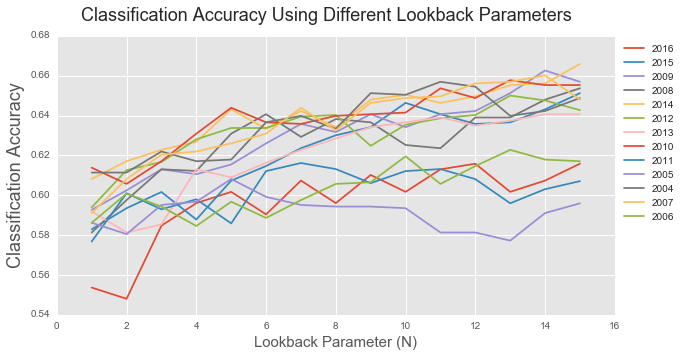

In [22]:
temp_df = all_games_lookback[all_games_lookback["season_id"] >= "22004"]
graph_lookback(temp_df, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

Based off of the above graph, and prediction accuracies for each model (done below), we decide that the best option is N=11.

<a id='Additional Features'></a>
## 5. Additional Features
While building our model, we decided to add additional features that could be possibly significant in predicting win/losses. Both of these features are implemented in [fivethirtyeight's](http://fivethirtyeight.com/features/how-our-2015-16-nba-predictions-work/) 2015-16 NBA prediction model.

<a id='Altitude'></a>
### 5A. Altitude
A potiential feature is the altitude of the stadium. The Denver Nuggets and Utah Jazz have stadiums that are at very high elevations (5280 ft and 4226 ft, respectively). At these elevations, it is thought that vistor teams have a possible disadvantage due to the fact they are not accustomed to lower oxygen levels. While this hypothesis constantly debated, it is true that the home team consistently has a larger home court advantage compared to other teams.

Since there are only 30 teams in the current NBA League, it was simpler to manually check elevations at each stadium. Below we insert the altitude column in the dataframe.

In [38]:
#temp_df = home_games_with_cutoff[home_games_with_cutoff['season_id']>="22005"]
temp_df = all_games[all_games['season_id'] >= '22005']
#temp_df = new_years_df[new_years_df['is_home'] == 1]

temp_df.head()
altitude = {'Chicago Stags': 615, 'Buffalo Braves': 600, 'Washington Bullets': 400, 'Toronto Huskies': 249, 
            'Los Angeles Lakers': 233, 'Chicago Bulls': 615, 'Washington Capitols': 200, 'Providence Steamrollers': 75, 
            'Charlotte Bobcats': 751, 'Capital Bullets': 200, 'New Orleans Pelicans': 13, 'San Diego Rockets': 62, 
            'Milwaukee Hawks': 617, 'Philadelphia 76ers': 39, 'Philadelphia Warriors': 39, 'Chicago Packers': 615, 
            'New Orleans Jazz': 20, 'Detroit Pistons': 961, 'Boston Celtics': 141, 'Miami Heat': 24, 
            'Minneapolis Lakers': 830, 'Orlando Magic': 82, 'Portland Trail Blazers': 50, 'Rochester Royals': 505, 
            'Golden State Warriors': 43, 'Sheboygan Redskins': 630, 'New York Knicks': 33, 'St. Louis Hawks': 465, 
            'Indianapolis Olympians': 715, 'Washington Wizards': 205, 'Kansas City Kings': 910, 'Utah Jazz': 4226, 
            'Ft. Wayne Zollner Pistons': 600, 'Pittsburgh Ironmen': 1365, 'New Jersey Nets': 33, 'New York Nets': 33, 
            'Dallas Mavericks': 430, 'Sacramento Kings': 30, 'New Orleans/Oklahoma City Hornets': 20, 
            'Los Angeles Clippers': 305, 'San Antonio Spurs': 650, 'Vancouver Grizzlies': 171, 
            'Oklahoma City Thunder': 1201, 'Waterloo Hawks': 1079, 'Charlotte Hornets': 751, 'Anderson Packers': 879, 
            'Syracuse Nationals': 380, 'Kansas City-Omaha Kings': 910, 'Cincinnati Royals': 482, 'Cleveland Rebels': 653, 
            'Milwaukee Bucks': 617, 'Phoenix Suns': 39, 'LA Clippers': 305, 'Memphis Grizzlies': 337, 
            'Tri-Cities Blackhawks': 1050, 'Toronto Raptors': 249, 'Houston Rockets': 43, 'New Orleans Hornets': 13, 
            'Chicago Zephyrs': 594, 'Minnesota Timberwolves': 830, 'Detroit Falcons': 600, 'Indiana Pacers': 715, 
            'San Diego Clippers': 62, 'Seattle SuperSonics': 518, 'Cleveland Cavaliers': 653, 'Atlanta Hawks': 1050, 
            'Brooklyn Nets': 33, 'Indianapolis Jets': 715, 'Baltimore Bullets': 480, 'San Francisco Warriors': 52, 
            'St. Louis Bombers': 465, 'Denver Nuggets': 5280}
altitude_dict = {}
curr_names = temp_df["team_name"].tolist()
for key in altitude:
    if key not in curr_names:
        continue
    else:
        filtered_df = temp_df[temp_df['team_name'] == key]
        cor_id = filtered_df["team_id"].iloc[0]
        altitude_dict[str(cor_id)] = altitude[key]
### adding a new elevation column
elevation = np.zeros(len(temp_df), dtype = np.int64)
temp_df = temp_df.assign(elevation = elevation)

for (index, row) in temp_df.iterrows():
        location = row['is_home']
        if location == 1: # at home
            alt = altitude_dict[str(row["team_id"])]
            temp_df.set_value(index, 'elevation', alt)
        else:
            alt = altitude_dict[str(row["opp_team_id"])]
            temp_df.set_value(index, 'elevation', alt)
temp_df.head()

,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,min,fgm,...,away_avg_pt_diff,home_win_pct_N,away_win_pct_N,away_win_pct_as_away,home_win_pct_as_home,home_back_to_back,away_back_to_back,home_game_count,away_game_count,elevation
88973,22005,1610612758,SAC,Sacramento Kings,20500025,2005-11-01,SAC @ NOK,L,240,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13
88093,22005,1610612740,NOK,New Orleans/Oklahoma City Hornets,20500025,2005-11-01,NOK vs. SAC,W,240,35.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13
88251,22005,1610612743,DEN,Denver Nuggets,20500002,2005-11-01,DEN @ SAS,L,240,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,650
86993,22005,1610612756,PHX,Phoenix Suns,20500003,2005-11-01,PHX vs. DAL,L,290,42.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39
86992,22005,1610612755,PHI,Philadelphia 76ers,20500001,2005-11-01,PHI vs. MIL,L,265,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39


<a id='Travel Distance'></a>
### 5B. Travel Distance (2005+)
Another potential useful feature is the distance traveled by a team to get to the current location. This is related to fatigue, as teams will likely be tired from the flights, and the time zone changes can be distorting. We wish to add features `home_mileage` and `away_mileage` to indicate the number of miles the team traveled to get to the current game.

To do this, we will use the library geopy to get coordinates and to calculate distances (distance will be calculated using the vincenty formula). We will need to manually create dictionaries mapping teams to locations. Because these need to be manually created, we limit the year scope to include on 2005+. We do not think this limitation will be significant since we know that recent years are the most important.

In [40]:
from geopy.geocoders import Nominatim
from geopy.distance import vincenty

# Only consider years after 2005
#temp_df = all_games[all_games['season_id'] >= '22005']
team_names = temp_df['team_name'].unique().tolist()
#print len(team_names), team_names

team_id_list = temp_df['team_id'].unique().tolist()

# Dictionary mapping of team_id to team_name
id_team = dict()
for team_id in team_id_list:
    temp_df_1 = temp_df[temp_df['team_id'] == team_id]
    id_team[team_id] = temp_df_1['team_name'].unique().tolist()

# Dictionary mapping of team_name to seasons
team_seasons = dict()
for team_name in team_names:
    temp_df_1 = temp_df[temp_df['team_name'] == team_name]
    team_seasons[team_name] = temp_df_1['season_id'].unique().tolist()

# Dictionary mapping team name to location
name_location = {'Dallas Mavericks': 'Dallas, Texas',
                'New Orleans/Oklahoma City Hornets': 'Oklahoma City, Oklahoma',
                'Milwaukee Bucks': 'Milwaukee, Wisconsin',
                'San Antonio Spurs': 'San Antonio, Texas',
                'Philadelphia 76ers': 'Philadelphia, Pennsylvania',
                'Phoenix Suns': 'Phoenix, Arizona',
                'Denver Nuggets': 'Denver, Colorado',
                'Sacramento Kings': 'Sacramento, California',
                'Atlanta Hawks': 'Atlanta, Georgia',
                'Miami Heat' : 'Miami, Florida', 
                'Toronto Raptors': 'Toronto, Ontario', 
                'New Jersey Nets': 'Newark, New Jersey', 
                'Houston Rockets': 'Houston, Texas', 
                'Boston Celtics': 'Boston, Massachusetts', 
                'Golden State Warriors' : 'Oakland, California', 
                'Utah Jazz': 'Salt Lake City, Utah', 
                'Seattle SuperSonics' : 'Seattle, Washington', 
                'Portland Trail Blazers': 'Portland, Oregon', 
                'Indiana Pacers' : 'Indianapolis, Indiana', 
                'Minnesota Timberwolves' : 'Minneapolis, Minnesota', 
                'Washington Wizards': 'Washington D.C., Virginia',
                'Chicago Bulls' : 'Chicago, Illinois', 
                'New York Knicks': 'New York City, New York', 
                'Cleveland Cavaliers' : 'Cleveland, Ohio', 
                'Charlotte Bobcats' : 'Charlotte, North Carolina',
                'Detroit Pistons' : 'Detroit, Michigan', 
                'Memphis Grizzlies' : 'Memphis, Tennessee', 
                'Orlando Magic' : 'Orlando, Florida', 
                'Los Angeles Clippers' : 'Los Angeles, California', 
                'Los Angeles Lakers' : 'Los Angeles, California', 
                'New Orleans Hornets' : 'New Orleans, Louisiana', 
                'Oklahoma City Thunder': 'Oklahoma City, Oklahoma', 
                'Brooklyn Nets': 'Brooklyn, New York', 
                'New Orleans Pelicans' : 'New Orleans, Louisiana', 
                'Charlotte Hornets' : 'Charlotte, North Carolina', 
                'LA Clippers' : 'Los Angeles, California'}

# Dictionary mapping location to (latitude, longitude)
location_latlong = dict()
geolocator = Nominatim()
for key,value in name_location.iteritems():
    geo_loc = geolocator.geocode(value)
    (lat1, long1) = (geo_loc.latitude, geo_loc.longitude)
    location_latlong[value] = (lat1,long1)
    
def get_team_location(team_id, season_id):
    """ Given a team id and the season_id, returns a string containing the location of the team stadium
    Input: 
        team_id (int): team id
        season_id (str): season id 
    Output:
        (str) 
    """
    names = id_team[team_id]
    
    team_name = None
    
    for name in names:
        seasons = team_seasons[name]
        #print seasons, name
        if season_id in seasons:
            team_name = name
            
    if team_name == None:
        print (team_id, season_id, names)
        assert(False)
    
    return name_location[team_name]

def add_mileage(league_df):
    geolocator = Nominatim()
    seen_distances = dict()
    
    new_df = league_df.sort_values('game_date')
    home_mileage = np.zeros(len(new_df))
    away_mileage = np.zeros(len(new_df))
    
    new_df = new_df.assign(home_mileage = home_mileage)
    new_df = new_df.assign(away_mileage = away_mileage)
    

    home_mileage = np.zeros(len(new_df))
    away_mileage = np.zeros(len(new_df))
    
    # Ddd features
    grouped = new_df.groupby(['season_id'])
    groupList = [grouped.get_group(x) for x in grouped.groups]
    
    for season_df in groupList:
        running_locations = dict()
        
        for team in season_df['team_id'].unique():
            # track list of locations played at
            running_locations[team] = []
        
        # sort season by day
        season_df = season_df.sort_values('game_date')
        
        seen_games = set()
        
        for (index, row) in season_df.iterrows():
            is_home = row['is_home']
            team_id = row['team_id']
            opp_team_id = row['opp_team_id']
            game_id = row['game_id']
            season_id = row['season_id']
            
            if is_home == 1:
                home_team_id = team_id
                away_team_id = opp_team_id
            else:
                home_team_id = opp_team_id
                away_team_id = team_id
                
            
            home_games_count = row['home_game_count']
            away_games_count = row['away_game_count']
            
            home_mileage = 0
            away_mileage = 0
            
            curr_location = get_team_location(home_team_id, season_id)

            (curr_lat, curr_long) = location_latlong[curr_location]

            if home_games_count > 0:
                location_list = running_locations[home_team_id]
                assert(len(location_list) == home_games_count)
                last_location = location_list[len(location_list) - 1]
                (last_lat, last_long) = location_latlong[last_location]

                str1 = curr_location + last_location
                str2 = last_location + curr_location

                if str1 in seen_distances:
                    home_mileage = seen_distances[str1]
                elif str2 in seen_distances:
                    home_mileage = seen_distances[str2]
                else:
                    home_mileage = vincenty((last_lat,last_long), (curr_lat,curr_long)).miles
                    seen_distances[str1] = home_mileage

            if away_games_count > 0:
                location_list = running_locations[away_team_id]
                assert(len(location_list) == away_games_count)
                last_location = location_list[len(location_list) - 1]

                (last_lat, last_long) = location_latlong[last_location]

                str1 = curr_location + last_location
                str2 = last_location + curr_location

                if str1 in seen_distances:
                    away_mileage = seen_distances[str1]
                elif str2 in seen_distances:
                    away_mileage = seen_distances[str2]
                else:
                    away_mileage = vincenty((last_lat,last_long), (curr_lat,curr_long)).miles
                    seen_distances[str1] = away_mileage

            new_df.set_value(index, 'home_mileage', home_mileage)
            new_df.set_value(index, 'away_mileage', away_mileage)
            
            if game_id in seen_games:
                running_locations[home_team_id].append(curr_location)
                running_locations[away_team_id].append(curr_location)
                
            seen_games.add(game_id)
            
    return new_df

In [41]:
mileage_df = add_mileage(all_games[all_games['season_id']>='22005'])
mileage_df.tail()

,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,min,fgm,...,home_win_pct_N,away_win_pct_N,away_win_pct_as_away,home_win_pct_as_home,home_back_to_back,away_back_to_back,home_game_count,away_game_count,home_mileage,away_mileage
113319,22016,1610612763,MEM,Memphis Grizzlies,21600351,2016-12-10,MEM vs. GSW,W,240,38.0,...,0.750,0.875,0.916667,0.692308,0.0,0.0,24.0,23.0,0.000000,1250.023004
113320,22016,1610612764,WAS,Washington Wizards,21600346,2016-12-10,WAS vs. MIL,W,240,40.0,...,0.500,0.625,0.428571,0.500000,0.0,1.0,21.0,21.0,0.000000,636.193735
113299,22016,1610612757,POR,Portland Trail Blazers,21600348,2016-12-10,POR @ IND,L,240,40.0,...,0.500,0.500,0.384615,0.666667,1.0,0.0,23.0,24.0,764.014734,383.691525
113426,22016,1610612766,CHA,Charlotte Hornets,21600349,2016-12-10,CHA @ CLE,L,240,39.0,...,0.625,0.750,0.666667,0.833333,1.0,1.0,21.0,23.0,0.000000,435.474905
113457,22016,1610612762,UTA,Utah Jazz,21600354,2016-12-10,UTA vs. SAC,W,240,37.0,...,0.750,0.375,0.333333,0.583333,0.0,1.0,24.0,22.0,0.000000,533.423519


<a id='Modeling'></a>
## 6. Modeling
We are finally ready to do some predictions! We train our models on 2005-06 to 2009-10 (5 seasons - 5393 games) and we validate on 2010-11 to 2012-13 (3 seasons - 3450 games). Note that code for Linear Regression and Logistic Regression is in the R file.

<a id='Naive Approach'></a>
### 6A. Naive Approach
The naive approach is to choose the team with the better record so far. If the records are the same, we will classify the home team as the winner.

In [ ]:
def naive_approach_accuracy(home_games_df, season_id_list):
    """ Given a df containing ALL HOME game logs, 
        season_id, returns accuracy of naive classification
    Input:
        league_df (pandas.DataFrame): dataframe containing post-processed league logs (both HOME and AWAY)
        season_id (int or string): season ID number
    Output:
        (int): number of games team won in season
    """
    
    correct = 0
    total = 0
    
    for season_id in season_id_list:
        season_id = str(season_id)

        season_df = home_games_df[(home_games_df['season_id'] == season_id)]
        for (index, row) in season_df.iterrows():
            home_team_pct = row['home_win_pct']
            away_team_pct = row['away_win_pct']
            wl = row['wl_binary']
            classification = 0

            if (home_team_pct >= away_team_pct):
                classification = 1
            if classification == wl:
                correct += 1
            total += 1
        
    return correct/float(total)

print naive_approach_accuracy(home_games,["22010","22011","22012"])
    
def graph_naive(home_games_df):
    """ Given a df containing ALL HOME game logs, 
        graph_naive graphs the naive classification accuracy across seasons
    Input:
        home_games_df (pandas.DataFrame): dataframe containing post-processed 
            league logs (HOME)
    Output:
        None
    """
    season_list = home_games_df['season_id'].unique().tolist()
    seasons = []
    naives = []
    for season in season_list:
        season_df = league_df[league_df['season_id'] == season]
        naives.append(naive_approach_accuracy(home_games_df, [season]))
        #pt_diff = season_df['plus_minus'].values
        #pt_diff = np.apply_along_axis(lambda x: np.abs(x), 0, pt_diff)
        seasons.append(int(season[1:]))
        #avg_pt_diffs.append(np.mean(pt_diff))
    fig = plt.figure()
    fig.suptitle('Naive Classification Accuracy',fontsize=12)
    plt.xlabel('Season Starting Year')
    plt.ylabel('Accuracy')
    plt.plot(seasons, naives, seasons, 
                  np.poly1d(np.polyfit(seasons, naives, 1))(np.unique(seasons)))

graph_naive(home_games)

<a id='Linear Regression Model'></a>
### 6B. Linear Regression Model

Our first approach of modeling our features was to use a multivariate linear regression model.

$$y_{i} = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + ... + \theta_{n-1}x_{n-1}$$
More consisely,
$$ y_{i} = \sum_{i=1}^{n} \theta_{i} x_{i}$$

To predict `plus_minus`, we include the following features in our model:
- home_win_pct
- away_win_pct
- home_win_pct_N
- away_win_pct_N
- home_back_to_back
- away_back_to_back
- home_win_pct_as_home
- away_win_pct_as_away
- away_back_to_back*away_win_pct_as_away
- elevation
- elevation*home_win_pct_as_home
- home_mileage

Note that we decided to not include certain features. We noticed that `home_avg_pt_diff` and `away_avg_pt_diff` both had very high multicollinearity (r-squared = 0.98) against `home_win_pct` and `away_win_pct`, repectively, we disregarded these features. `home_avg_pt_diff` and `away_avg_pt_diff`.
In addition we added interaction terms between `away_back_to_back` and `away_win_pct_as_away` as well as `elevation` and `home_win_pct_as_home`.
We checked that our model followed linear assumptions by checking residual plots against each feature as well as a Q-Q plot for normality assumptions. A lambda value of 1 in a boxcox shows that there is no need to transform our response variable.
<img src="resids2.png"> <img src="qqandboxcox.png">



<a id='Logistic Regression Model'></a>
### 6C. Logistic Regression Model
Our second approach is using a binary logistic regression model. Our response variable is win or loss.

To predict win/loss, we use the following features:
- 

<a id='SVM'></a>
### 6D. Support Vector Machines

<a id='Linear Regression Model'></a>
## 7. Final Results and Concluding Thoughts

<table>
  <tr>
    <th>Method</th>
    <th>Validation Accuracy Rate</th>
    <th>Test Set Accuracy Rate</th>
  </tr>
  <tr>
    <td>Naive Approach</td>
    <td>Maria Anders</td>
    <td>Germany</td>
  </tr>
  <tr>
    <td>Linear Regression</td>
    <td>Francisco Chang</td>
    <td>Mexico</td>
  </tr>
  <tr>
    <td>Logistic Regression</td>
    <td>Roland Mendel</td>
    <td>Austria</td>
  </tr>
  <tr>
    <td>Support Vector Machines</td>
    <td>Helen Bennett</td>
    <td>UK</td>
  </tr>
</table>

### Sources
1. `http://homepages.cae.wisc.edu/~ece539/fall13/project/AmorimTorres_rpt.pdf`